In [40]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bank_EDA").getOrCreate()

Dataset Link - https://www.kaggle.com/datasets/ksabishek/massive-bank-dataset-1-million-rows/data

In [9]:
df = spark.read.csv("/content/bankdataset (2).csv",header=True,inferSchema=True)
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Domain: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Value: integer (nullable = true)
 |-- Transaction_count: integer (nullable = true)



In [10]:
df.show(5)

+--------+-------------+--------+------+-----------------+
|    Date|       Domain|Location| Value|Transaction_count|
+--------+-------------+--------+------+-----------------+
|1/1/2022|    RESTRAUNT|    Bhuj|365554|             1932|
|1/1/2022|  INVESTMENTS|Ludhiana|847444|             1721|
|1/1/2022|       RETAIL|     Goa|786941|             1573|
|1/1/2022|INTERNATIONAL| Mathura|368610|             2049|
|1/1/2022|    RESTRAUNT| Madurai|615681|             1519|
+--------+-------------+--------+------+-----------------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import to_timestamp
df = df.withColumn("Date", to_timestamp("Date","yyyy-MM-dd"))
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Domain: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Value: integer (nullable = true)
 |-- Transaction_count: integer (nullable = true)



In [15]:
print("Rows",df.count())

Rows 43657


In [18]:
print("columns:",len(df.columns))

columns: 5


In [22]:
from pyspark.sql.functions import col, sum as _sum

# Count nulls per column
null_counts = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()


+-----+------+--------+-----+-----------------+
| Date|Domain|Location|Value|Transaction_count|
+-----+------+--------+-----+-----------------+
|43657|     0|       0|    0|                0|
+-----+------+--------+-----+-----------------+



## 1. Average transaction value everyday for each domain

In [26]:
from pyspark.sql.functions import col, avg

# Create average transaction value column
df = df.withColumn("avg_txn_value", col("Value") / col("Transaction_count"))

# Group by Date and Domain, then calculate average transaction value per day per domain
avg_txn_per_day_domain = df.groupBy("Domain") \
    .agg(avg("avg_txn_value").alias("avg_txn_per_domain_per_day"))

# Show first 10 rows
avg_txn_per_day_domain.show(10)


+-------------+--------------------------+
|       Domain|avg_txn_per_domain_per_day|
+-------------+--------------------------+
|    RESTRAUNT|         650.6562440066156|
|INTERNATIONAL|         641.6989564078532|
|       PUBLIC|         642.6369965415066|
|    EDUCATION|         643.9371916549254|
|       RETAIL|         651.4989019538593|
|      MEDICAL|         642.5644541697869|
|  INVESTMENTS|         645.9478051443969|
+-------------+--------------------------+



## 2. Average transaction value for every city/location over the year

In [29]:
avg_txn_city = df.groupBy("Location").agg(avg("avg_txn_value").alias("avg_txn_value_city"))
avg_txn_city.orderBy(col("avg_txn_value_city").desc()).show(10)


+---------+------------------+
| Location|avg_txn_value_city|
+---------+------------------+
|   Indore| 682.4368136909374|
|   Ranchi| 674.8052161118887|
|   Bokaro| 673.2261078200953|
|     Durg| 672.5964656677794|
|     Pune| 671.6561895018799|
|      Ara| 665.2182578274602|
| Banglore| 663.9856216770412|
| Tirumala| 662.0739833220692|
|  Lucknow| 660.8307536158907|
|Ahmedabad| 659.3983456906452|
+---------+------------------+
only showing top 10 rows



## 3. Priority list of domains (highest active domain)

In [31]:
domain_priority = df.groupBy("Domain") \
    .agg({"Transaction_count": "sum"}) \
    .withColumnRenamed("sum(Transaction_count)", "total_transactions") \
    .orderBy(col("total_transactions").desc())

domain_priority.show()



+-------------+------------------+
|       Domain|total_transactions|
+-------------+------------------+
|  INVESTMENTS|           9325343|
|    EDUCATION|           9301767|
|       PUBLIC|           9277890|
|INTERNATIONAL|           9267914|
|      MEDICAL|           9237933|
|       RETAIL|           9120659|
|    RESTRAUNT|           8855386|
+-------------+------------------+



## 4. Average transaction count for each city

In [32]:
avg_txn_count_city = df.groupBy("Location") \
    .agg(avg("Transaction_count").alias("avg_txn_count_city"))

avg_txn_count_city.orderBy(col("avg_txn_count_city").desc()).show(10)


+--------+------------------+
|Location|avg_txn_count_city|
+--------+------------------+
|     Mon|1531.6782608695653|
|Varanasi|1519.4668117519043|
|   Betul| 1515.156146179402|
|    Doda|1510.3884210526317|
| Bikaner|1501.3649946638207|
|   Surat|1499.6604747162023|
|  Konark|1498.6164383561643|
|  Bombay| 1498.396017699115|
|     Goa|1496.2648592283629|
|  Kannur|1495.9818181818182|
+--------+------------------+
only showing top 10 rows



## 5) Visualization

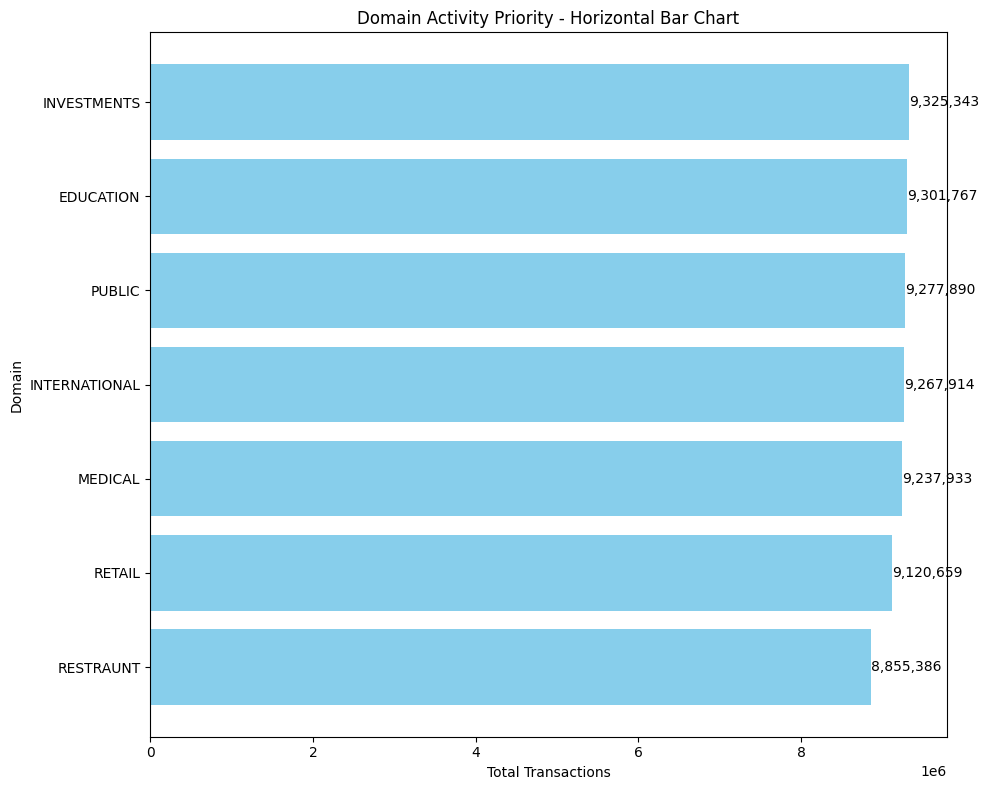

In [39]:
pandas_df = domain_priority.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
bars = plt.barh(pandas_df["Domain"], pandas_df["total_transactions"], color='skyblue')
plt.xlabel("Total Transactions")
plt.ylabel("Domain")
plt.title("Domain Activity Priority - Horizontal Bar Chart")
plt.gca().invert_yaxis()  # highest value on top

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2, f'{int(width):,}', va='center')

plt.tight_layout()
plt.show()
